# PART I

-----------------------

# Creating the dataset to play with.

- Merge 4 datasets with different lenght by date
- Google searches dataset:
    - There are 3 columns: Date, keywords, and score, grouped by week. It needs to be structured like a column for each keyword, and rows with the score (the score will be the trend index of Google Trends).
    
- Spanish news (3 datasets):
    - There are 3 columns: Date, keyword and sentiment. The same keyword can appear many times the same day.
    - A column counting occurrences per day of a keyword must be created, also a column with mean sentiment per day.
    - Then a column called score will be created, multiplying occurrences * mean.
    - Then the final datset will be Date, as much columns as keywords, every column will have the score mentioned above as rows. Everything grouped by week.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA as pca
from scipy import stats
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import matplotlib.font_manager

In [2]:
df_political=pd.read_csv("./input/dashboard_spanish_news_political.csv.gz",compression='gzip', header=0, quotechar='"', error_bad_lines=False)
df_political.sort_values(by=["Date"],inplace=True)

df_economical=pd.read_csv("./input/dashboard_spanish_news_economical.csv.gz",compression='gzip', header=0, quotechar='"', error_bad_lines=False)
df_economical.sort_values(by=["Date"],inplace=True)

df_social=pd.read_csv("./input/dashboard_spanish_news_social.csv.gz",compression='gzip', header=0, quotechar='"', error_bad_lines=False)
df_social.sort_values(by=["Date"],inplace=True)

df_google=pd.read_csv("./input/data_pytrends.csv",index_col=[0])
df_google.sort_values(by=["date"],inplace=True)

# Dataset previews:

- With news, I need to count occurrences, calculate the average of sentiment, multiply both to create a new column.


In [3]:
datasets_raw=[df_political, df_social, df_economical, df_google]
for d in datasets_raw:
    
    display(d.tail())
    column_list= d.columns
    print("Unique keywords: ", d[column_list[0]].unique(),"\n","\n",
         "Shape: ", d.shape,"\n","\n"
         )

,political,Date,Sentiment
55731,juicio,2020-12-20,-4.49
55735,juicio,2020-12-20,-1.08
55734,juicio,2020-12-20,-8.04
55732,juicio,2020-12-20,-6.47
55773,ejercito,2020-12-20,-1.78


Unique keywords:  ['juicio' 'ejercito' 'vigilancia' 'protestas' 'inestabilidad_politica'
 'seguridad_nacional' 'corrupcion' 'refugiados' 'rebelion' 'terrorismo'
 'extremismo' 'precio_petroleo'] 
 
 Shape:  (55899, 3) 
 



,social,Date,Sentiment
42788,emergencia_sanitaria,2020-12-20,-4.60
42787,emergencia_sanitaria,2020-12-20,-4.65
42786,emergencia_sanitaria,2020-12-20,-2.00
42797,emergencia_sanitaria,2020-12-20,-3.45
42877,enfermedades_muy_infecciosas,2020-12-20,-0.14


Unique keywords:  ['enfermedades_muy_infecciosas' 'vacunas' 'emergencia_sanitaria'
 'inmigracion' 'agresion_sexual' 'ciencia' 'emprendimiento'
 'precio_vivienda' 'energias_renovables' 'censura_en_medios' 'subsidios'
 'racismo'] 
 
 Shape:  (42878, 3) 
 



,economical,Date,Sentiment
100,stock_market,2020-12-20,-4.16
99,stock_market,2020-12-20,-1.71
98,stock_market,2020-12-20,-2.56
966,incertidumbre_economica,2020-12-20,-5.53
950,incertidumbre_economica,2020-12-20,-2.92


Unique keywords:  ['pobreza' 'incertidumbre_economica' 'stock_market'
 'macroeconomia_deuda_y_vulnerabilidad' 'desempleo'
 'job_quality_&_labor_market_performance' 'libre_comercio'
 'inflacion_economica' 'precio_petroleo' 'quiebra_economica'
 'crecimiento_economico' 'banco_mundial' 'finanzas_y_bancos'
 'prosperidad_economica_y_finanzas'] 
 
 Shape:  (160349, 3) 
 



,keyword,date,trend_index
7139,yoga,2020-12-13,39
5915,examenes,2020-12-13,33
2243,podemos,2020-12-13,18
917,comparecencia,2020-12-13,4
8261,en familia,2020-12-13,62


Unique keywords:  ['zoom' 'yoga' 'crisis economica' 'badi' 'erte' 'vox' 'examenes'
 'refugiados' 'estado de alarma' 'psoe' 'idealista' 'paro' 'menu escolar'
 'meetic' 'uber' 'autonomo' 'bullying' 'hipoteca' 'sepe' 'taxi' 'hangouts'
 'corrupcion' 'tinder' 'en casa' 'clases online' 'piso barato' 'infeccion'
 'videollamada' 'pandemia' 'negocio online' 'crisis politica'
 'productividad' 'independentismo' 'videoconferencia' 'medico'
 'coronavirus' 'emprendimiento' 'cursos online' 'residencia ancianos'
 'skype' 'en familia' 'meditacion' 'barometro' 'remoto' 'desescalada'
 'comparecencia' 'teletrabajo' 'formacion' 'embarazo' 'pp' 'nacionalismo'
 'amazon' 'just eat' 'inmigracion' 'comedor social' 'compartir piso'
 'steam' 'mas pais' 'desempleo' 'uber eats' 'banco alimentos'
 'manifestacion' 'caritas' 'cruz roja' 'hbo' 'hacer deporte' 'pnv'
 'deshaucio' 'ayuda alquiler' 'podemos' 'disney' 'glovo' 'netflix'
 'deliveroo' 'bildu' 'ciudadanos' 'cabify' 'erc' 'divorcio' 'protesta'
 'compromis'] 
 
 

With Google searches, what we have is the Trending index. Score 100 means that from the requested period of time, in this week the maximum of occurrences were reached, and everything else get normalize by that peak. It is not possible to request the real number of occurrences.

# Data Processing

### Working with the Google dataset: 

- Creating a column for each keyword with the trend_index value.

I'm going to create a dataframe with the set of dates, and append the score of keywords to this dataset (kind of get dummies, but I can't do that, I have already the units I want for each column)

In [4]:
# creating df
df_google_dates=pd.DataFrame()

# creating the Date column in new dataset
df_google_dates["date"]=list(set(df_google["date"]))
df_google_dates["date"]=pd.to_datetime(df_google_dates["date"])
df_google_dates.sort_values(by=["date"],inplace=True)
df_google_dates.tail()

,date
32,2020-11-15
48,2020-11-22
20,2020-11-29
2,2020-12-06
88,2020-12-13


In [5]:
# dates are a pain in the ass, you know right?
df_google_dates.date.dtypes

dtype('<M8[ns]')

 - append to the empty dataframe with dates

In [6]:
# Creating the new columns. Trend index with the name of the corresponding keyword
keyword_list=list(set(df_google["keyword"]))
keyword_list.sort()
for k in keyword_list:
    df_google_dates[k]=df_google[(df_google['keyword'] == k)]["trend_index"].tolist()
#df_google_dates.index=df_google_dates["date"]
#df_google_dates.drop(columns="date",inplace=True)
df_google_dates.tail()

,date,amazon,autonomo,ayuda alquiler,badi,banco alimentos,barometro,bildu,bullying,cabify,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
32,2020-11-15,81,49,27,26,100,47,47,31,7,...,23,16,82,46,76,10,7,8,42,23
48,2020-11-22,98,42,21,39,37,35,22,20,8,...,23,12,66,49,89,10,7,7,42,20
20,2020-11-29,85,54,22,17,14,25,18,22,11,...,34,15,76,37,81,7,7,7,34,18
2,2020-12-06,90,31,21,41,10,33,10,23,10,...,28,12,98,48,82,10,8,7,39,16
88,2020-12-13,88,44,25,31,14,13,6,18,13,...,28,10,79,35,57,9,9,6,39,18


**This will be our target in the ML regression"**: Unemployment

In [7]:
df_google_dates.rename(columns={'desempleo':"unemployment"}, inplace=True)

### Working with news datasets. 

I'll need to:

- Create a column for each keyword.
- Count occurrences of that keyword.
- Measure average sentiment.
- Group data by week, starting on sunday, to merge with the Google dataset.
- Combine occurrences and sentiment into one column representative of both, for each keyword.

In [8]:
# let's pplay with the 1st dataset and a random keyword, for instance
df_political[df_political["political"]=="juicio"].head()

,political,Date,Sentiment
15784,juicio,2019-01-01,-6.08
15773,juicio,2019-01-01,0.18
15774,juicio,2019-01-01,0.18
15775,juicio,2019-01-01,-1.20
15776,juicio,2019-01-01,-1.20


- So, I need to measure the average of sentiment of each keyword per day

In [9]:
df_political[df_political["political"]=="juicio"].groupby("Date").mean().head()

,Sentiment
Date,
2019-01-01,-2.930000
2019-01-02,-3.986667
2019-01-03,-2.350000
2019-01-04,-4.822500
2019-01-05,-4.723333


- Also, counting occurrences of that keyword

In [10]:
df_political[df_political["political"]=="juicio"].groupby("Date").count().head()

,political,Sentiment
Date,,
2019-01-01,14,14
2019-01-02,18,18
2019-01-03,40,40
2019-01-04,16,16
2019-01-05,60,60


- Let's use an aggregate to perform both

In [11]:
df2=df_political[df_political["political"]=="juicio"].groupby(["Date"]).agg(['count','mean'])
# erase multiindex
df2.columns=df2.columns.droplevel(0)
df2.tail()

,count,mean
Date,,
2020-12-16,21,-5.710952
2020-12-17,13,-4.783077
2020-12-18,12,-8.670833
2020-12-19,8,-5.951250
2020-12-20,11,-3.266364


- Great, now let's resample by week, starting on Sunday, like the Google Searches dataset

In [12]:
df2.index = pd.to_datetime(df2.index)
df2 = df2.resample('W-SUN').mean() #weekly totals
# score is how we are going to measure the keywords
df2["score"]=df2["count"]*df2["mean"]
df2.tail()

,count,mean,score
Date,,,
2020-11-22,9.000000,-4.722266,-42.500395
2020-11-29,17.000000,-5.013151,-85.223565
2020-12-06,20.285714,-4.461923,-90.513293
2020-12-13,9.428571,-5.743085,-54.149087
2020-12-20,14.857143,-5.962872,-88.591243


ok, now I know how to do it, then let's continue creating a function to perform this for every keyword in every Spanish news datasets.

- I need to create an empty dataframe.
- loop for each keyword from a set of keywords.
- perform what i did before for all keywords.
- concat to the mepty dataframe.
- put all this in a function.

In [13]:
# pending of erasing this and writing it in a separate script
def creating_dataset(df,column):
    '''
    Column is the column in which are allocated the keywords, for every case: political, social and economical columns
    '''
    df["Date"]=pd.to_datetime(df["Date"])
    # list of new columns
    list_keywords=list(set(df[column]))
    # creating empty dataframe to append info
    df_final=pd.DataFrame()
    df_final["date"]=list(set(df["Date"]))
    
    for k in list_keywords:
        # creating a new dataframe for every keyword in the column, getting the occurrences of keyword and mean of sentiment
        df4=pd.DataFrame()
        df4=df[df[column]==k].groupby(["Date"]).agg(['count','mean'])
        # erase multiindex
        df4.columns=df4.columns.droplevel(0)
        # this will be our score, occurrences * mean 
        df4[k]=df4["count"]*df4["mean"]
        # date column to perform the join by it
        df4["date"]=df4.index
        df4.drop(columns=["count","mean"],inplace=True)
        # this is where we combine the empty dataset, every keyword in its place
        df_final=df_final.merge(df4,how='left', left_on='date', right_on='date')

    # resampling 
    # this is weird: transform date column in index, group by, then transform again index in column, to make the further join
    df_final.index=df_final["date"]
    df_final = df_final.resample('W-SUN').mean() #weekly totals
    df_final.sort_values(by="date", ascending=True, inplace=True)
    df_final["date"]=df_final.index
    df_final.reset_index(drop=True, inplace=True)
    
    
    return df_final

In [14]:
dfp = creating_dataset(df_political,"political")
dfs = creating_dataset(df_social,"social")
dfe = creating_dataset(df_economical,"economical")

In [15]:
dfe.date.dtypes

dtype('<M8[ns]')

In [16]:
dfe.shape

(103, 15)

In [17]:
dfe.tail()

,precio_petroleo,inflacion_economica,desempleo,banco_mundial,finanzas_y_bancos,stock_market,quiebra_economica,prosperidad_economica_y_finanzas,pobreza,libre_comercio,job_quality_&_labor_market_performance,macroeconomia_deuda_y_vulnerabilidad,crecimiento_economico,incertidumbre_economica,date
98,NaN,NaN,-1.998333,NaN,0.42,-8.515714,-2.870,NaN,-17.824286,NaN,-13.128000,-4.920000,-2.690000,-254.740000,2020-11-22
99,NaN,NaN,-2.448000,NaN,NaN,-19.915714,NaN,-6.47,-22.805714,-3.25,-6.680000,-10.077500,-0.760000,-294.670000,2020-11-29
100,NaN,-6.310,-5.247500,NaN,NaN,-6.292857,-1.010,-4.47,-14.445714,NaN,-1.948000,-13.760000,-3.766667,-354.131429,2020-12-06
101,-2.64,-1.875,-3.762500,-2.87,NaN,-7.792857,NaN,NaN,-28.698571,-66.81,-3.913333,-0.543333,-2.610000,-337.195714,2020-12-13
102,NaN,3.210,-6.856667,NaN,NaN,-9.238571,-2.045,NaN,-29.917143,-6.18,-0.836667,-6.055000,NaN,-286.014286,2020-12-20


In [18]:
dfs.shape

(103, 13)

In [19]:
dfs.tail()

,enfermedades_muy_infecciosas,vacunas,ciencia,agresion_sexual,precio_vivienda,emprendimiento,emergencia_sanitaria,subsidios,censura_en_medios,inmigracion,energias_renovables,racismo,date
98,-31.867143,NaN,-1.501667,NaN,-4.32,-1.555,-91.004286,NaN,NaN,NaN,NaN,NaN,2020-11-22
99,-41.211429,-1.00,-8.197143,-7.465,0.36,8.960,-111.404286,NaN,NaN,1.840000,NaN,NaN,2020-11-29
100,-32.165714,2.85,-15.538333,-13.790,NaN,-4.700,-157.940000,NaN,NaN,4.112500,-3.66,NaN,2020-12-06
101,-44.785714,-3.13,-7.207500,-8.305,NaN,-0.810,-123.848571,NaN,NaN,-7.586667,0.62,NaN,2020-12-13
102,-25.485714,-1.00,-3.338333,NaN,NaN,NaN,-106.138571,NaN,NaN,-2.624000,NaN,NaN,2020-12-20


In [20]:
dfs.shape

(103, 13)

In [21]:
dfe.tail()

,precio_petroleo,inflacion_economica,desempleo,banco_mundial,finanzas_y_bancos,stock_market,quiebra_economica,prosperidad_economica_y_finanzas,pobreza,libre_comercio,job_quality_&_labor_market_performance,macroeconomia_deuda_y_vulnerabilidad,crecimiento_economico,incertidumbre_economica,date
98,NaN,NaN,-1.998333,NaN,0.42,-8.515714,-2.870,NaN,-17.824286,NaN,-13.128000,-4.920000,-2.690000,-254.740000,2020-11-22
99,NaN,NaN,-2.448000,NaN,NaN,-19.915714,NaN,-6.47,-22.805714,-3.25,-6.680000,-10.077500,-0.760000,-294.670000,2020-11-29
100,NaN,-6.310,-5.247500,NaN,NaN,-6.292857,-1.010,-4.47,-14.445714,NaN,-1.948000,-13.760000,-3.766667,-354.131429,2020-12-06
101,-2.64,-1.875,-3.762500,-2.87,NaN,-7.792857,NaN,NaN,-28.698571,-66.81,-3.913333,-0.543333,-2.610000,-337.195714,2020-12-13
102,NaN,3.210,-6.856667,NaN,NaN,-9.238571,-2.045,NaN,-29.917143,-6.18,-0.836667,-6.055000,NaN,-286.014286,2020-12-20


-----------------------------------------
-----------------------------------------

In [22]:
datasets = [ dfp, dfe, dfs,df_google_dates]

c=0
for d in datasets:
    c+=len(d.columns)

print("Number of attributes I have to play with: ",c)

#print(len(datasets))

Number of attributes I have to play with:  123


----------------------------------------------
----------------------------------------------

-  **don't worry by NAN, i'll deal with that later**

### Merging all datasets

- Create an empty dataframe.
- Create a column for it all dates
- Use a left join using the date column, to append in the proper place the keywords of all the other datasets

In [23]:
from datetime import datetime, date

In [24]:
# first of all let's discover the later date we have
#datasets = [ dfp, dfe, dfs,df_google_dates] 
date2 = []
for d in datasets:
    date2. append(d.date.max()) # get the later date of every dataset
    
date2 = max(date2) # get the higher of the latest
date2

Timestamp('2020-12-20 00:00:00')

In [25]:
# creating final dataset with everything
date1 = '2019-01-01'
 
mydates = pd.date_range(date1, date2, freq="W").tolist()
df_final=pd.DataFrame()
df_final["date"]=mydates
df_final['date']=pd.to_datetime(df_final["date"])
df_final.tail()

,date
98,2020-11-22
99,2020-11-29
100,2020-12-06
101,2020-12-13
102,2020-12-20


In [26]:
df_final.date.dtypes

dtype('<M8[ns]')

In [27]:
# datasets = [ dfp, dfe, dfs,df_google_dates]  already referenced before 

In [28]:
# Merging!
for d in datasets:
    df_final=df_final.merge(d,how='left', left_on="date", right_on="date",suffixes=["_1","_2"])

In [29]:
df_final.shape

(103, 120)

In [30]:
print(list(df_final.columns)) # basically all reference one by one before

['date', 'rebelion', 'extremismo', 'precio_petroleo_1', 'vigilancia', 'terrorismo', 'inestabilidad_politica', 'corrupcion_1', 'seguridad_nacional', 'refugiados_1', 'juicio', 'ejercito', 'protestas', 'precio_petroleo_2', 'inflacion_economica', 'desempleo', 'banco_mundial', 'finanzas_y_bancos', 'stock_market', 'quiebra_economica', 'prosperidad_economica_y_finanzas', 'pobreza', 'libre_comercio', 'job_quality_&_labor_market_performance', 'macroeconomia_deuda_y_vulnerabilidad', 'crecimiento_economico', 'incertidumbre_economica', 'enfermedades_muy_infecciosas', 'vacunas', 'ciencia', 'agresion_sexual', 'precio_vivienda', 'emprendimiento_1', 'emergencia_sanitaria', 'subsidios', 'censura_en_medios', 'inmigracion_1', 'energias_renovables', 'racismo', 'amazon', 'autonomo', 'ayuda alquiler', 'badi', 'banco alimentos', 'barometro', 'bildu', 'bullying', 'cabify', 'caritas', 'ciudadanos', 'clases online', 'comedor social', 'comparecencia', 'compartir piso', 'compromis', 'coronavirus', 'corrupcion_2',

In [31]:
df_final=df_final.fillna(0)

In [32]:
df_final.to_csv("./tmp/dataset_before_sliding.csv") # it's just the autoamted script is divided into several ones
df_final.shape

(103, 120)

# Sliding time

- I'm going to create a new dataset with *unemployment*, my target column and date
- Remove *unemployment* from the old dataset
- In the old dataset, add 4 weeks to the date rows. In this way, everythin happening right now will be linked with unemployment 4 weeks ahead
- Merge the *unemployment* and date dataset with the old one with changed dates

Summing up, change the dates 4 weeks ahead of everything but *unemployment* column

In [33]:
from datetime import timedelta, datetime

In [34]:
dataset=pd.read_csv("./tmp/dataset_before_sliding.csv")
dataset.columns

Index(['Unnamed: 0', 'date', 'rebelion', 'extremismo', 'precio_petroleo_1',
       'vigilancia', 'terrorismo', 'inestabilidad_politica', 'corrupcion_1',
       'seguridad_nacional',
       ...
       'taxi', 'teletrabajo', 'tinder', 'uber', 'uber eats',
       'videoconferencia', 'videollamada', 'vox', 'yoga', 'zoom'],
      dtype='object', length=121)

In [35]:
dataset["date"]=pd.to_datetime(dataset["date"])
df_unemployment=pd.DataFrame(dataset[["date", "unemployment"]])
dataset.drop(columns=["unemployment",'Unnamed: 0'], inplace=True)

In [36]:
dataset["date"]=dataset["date"].apply(lambda x: x+timedelta(weeks=4))
dataset.tail()

,date,rebelion,extremismo,precio_petroleo_1,vigilancia,terrorismo,inestabilidad_politica,corrupcion_1,seguridad_nacional,refugiados_1,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
98,2020-12-20,-5.103333,0.00,0.00,-4.705000,-4.060000,-3.920,-25.255714,-1.505714,-4.363333,...,23.0,12.0,66.0,49.0,89.0,10.0,7.0,7.0,42.0,20.0
99,2020-12-27,-2.236667,0.00,0.00,-9.928571,-15.684000,0.710,-43.687143,-6.328000,-4.660000,...,34.0,15.0,76.0,37.0,81.0,7.0,7.0,7.0,34.0,18.0
100,2021-01-03,-22.630000,0.00,0.00,-7.828333,-12.983333,0.000,-60.852857,-5.020000,-6.390000,...,28.0,12.0,98.0,48.0,82.0,10.0,8.0,7.0,39.0,16.0
101,2021-01-10,-2.640000,-7.67,-2.64,-6.966667,-6.036667,0.000,-19.585714,-2.935000,-3.157500,...,28.0,10.0,79.0,35.0,57.0,9.0,9.0,6.0,39.0,18.0
102,2021-01-17,-1.535000,2.12,0.00,-4.851667,-9.918000,-9.505,-46.031429,-1.913333,-5.895000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# now let's merge again. outter to get all from both datasets
df=pd.merge(dataset,df_unemployment,how='outer', on=["date"],suffixes=(None,None))
df.sort_values(by=["date"],inplace=True)
df=df.fillna(0)

# great, everything but "unemployment" has been moved 4 weeks ahead
df.head() # go to the right to appreciate it

,date,rebelion,extremismo,precio_petroleo_1,vigilancia,terrorismo,inestabilidad_politica,corrupcion_1,seguridad_nacional,refugiados_1,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
103,2019-01-06,0.000000,0.000000,0.0,0.000,0.00,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
104,2019-01-13,0.000000,0.000000,0.0,0.000,0.00,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
105,2019-01-20,0.000000,0.000000,0.0,0.000,0.00,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0
106,2019-01-27,0.000000,0.000000,0.0,0.000,0.00,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
0,2019-02-03,-21.453333,-29.993333,0.0,-31.525,-82.14,-7.77,-92.164,-30.555,-6.425,...,1.0,57.0,27.0,12.0,2.0,2.0,34.0,47.0,5.0,18.0


In [38]:
df.tail() # go to the right to appreciate it

,date,rebelion,extremismo,precio_petroleo_1,vigilancia,terrorismo,inestabilidad_politica,corrupcion_1,seguridad_nacional,refugiados_1,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
98,2020-12-20,-5.103333,0.00,0.00,-4.705000,-4.060000,-3.920,-25.255714,-1.505714,-4.363333,...,12.0,66.0,49.0,89.0,10.0,7.0,7.0,42.0,20.0,0.0
99,2020-12-27,-2.236667,0.00,0.00,-9.928571,-15.684000,0.710,-43.687143,-6.328000,-4.660000,...,15.0,76.0,37.0,81.0,7.0,7.0,7.0,34.0,18.0,0.0
100,2021-01-03,-22.630000,0.00,0.00,-7.828333,-12.983333,0.000,-60.852857,-5.020000,-6.390000,...,12.0,98.0,48.0,82.0,10.0,8.0,7.0,39.0,16.0,0.0
101,2021-01-10,-2.640000,-7.67,-2.64,-6.966667,-6.036667,0.000,-19.585714,-2.935000,-3.157500,...,10.0,79.0,35.0,57.0,9.0,9.0,6.0,39.0,18.0,0.0
102,2021-01-17,-1.535000,2.12,0.00,-4.851667,-9.918000,-9.505,-46.031429,-1.913333,-5.895000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df.reset_index(drop=True,inplace=True)
# lets remove the first 4 rows. We don't have data in our X, just in our target, so it's redundant
df.drop([0,1,2,3], inplace=True)

In [40]:
#df.drop(columns=["Unnamed: 0"], inplace=True)
df

,date,rebelion,extremismo,precio_petroleo_1,vigilancia,terrorismo,inestabilidad_politica,corrupcion_1,seguridad_nacional,refugiados_1,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
4,2019-02-03,-21.453333,-29.993333,0.00,-31.525000,-82.140000,-7.770000,-92.164000,-30.555000,-6.425000,...,1.0,57.0,27.0,12.0,2.0,2.0,34.0,47.0,5.0,18.0
5,2019-02-10,-17.413333,-2.260000,0.00,-67.150000,-11.586667,-23.500000,-168.828571,-5.313333,-15.266667,...,1.0,45.0,39.0,9.0,4.0,1.0,27.0,44.0,4.0,22.0
6,2019-02-17,-26.305000,-5.644000,3.72,-49.556000,-145.260000,-36.120000,-106.468571,-3.220000,0.000000,...,0.0,44.0,100.0,14.0,3.0,2.0,15.0,46.0,3.0,20.0
7,2019-02-24,-26.570000,-4.226667,0.00,-14.530000,-34.084000,-24.146667,-106.342857,-16.080000,1.276000,...,1.0,45.0,83.0,10.0,3.0,2.0,11.0,50.0,4.0,21.0
8,2019-03-03,-28.106667,0.000000,0.00,-21.495000,-24.512000,-5.160000,-112.497143,-1.480000,-20.310000,...,3.0,56.0,37.0,10.0,3.0,2.0,13.0,51.0,3.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2020-12-20,-5.103333,0.000000,0.00,-4.705000,-4.060000,-3.920000,-25.255714,-1.505714,-4.363333,...,12.0,66.0,49.0,89.0,10.0,7.0,7.0,42.0,20.0,0.0
103,2020-12-27,-2.236667,0.000000,0.00,-9.928571,-15.684000,0.710000,-43.687143,-6.328000,-4.660000,...,15.0,76.0,37.0,81.0,7.0,7.0,7.0,34.0,18.0,0.0
104,2021-01-03,-22.630000,0.000000,0.00,-7.828333,-12.983333,0.000000,-60.852857,-5.020000,-6.390000,...,12.0,98.0,48.0,82.0,10.0,8.0,7.0,39.0,16.0,0.0
105,2021-01-10,-2.640000,-7.670000,-2.64,-6.966667,-6.036667,0.000000,-19.585714,-2.935000,-3.157500,...,10.0,79.0,35.0,57.0,9.0,9.0,6.0,39.0,18.0,0.0


In [41]:
print("I have ", len(df.columns)-1, " columns to play with")#columns=list(df.columns) 

I have  119  columns to play with


In [42]:
#df.to_csv("./tmp/dataset_final_processed.csv")

--------------------------------------------------------- 
---------------------------------------------------------

# New outliers removal approach
In development. Working one one in the end.

Notas para mi yo del futuro:
- get the index of outliers and non outliers.
- create a new column with "yes", "no" regarding it
- pca with 3 dimensions, colors depending on "yes" "no" value

In [43]:
# z-score
from datetime import datetime, date

In [44]:
# removing outliers
column_list=list(df.columns)
column_list.remove("date") # removing date because is no sense processing this column

In [45]:
# using zscore for each column
df_outliers=df[column_list]
z_scores = stats.zscore(df_outliers)
abs_z_scores = np.abs(z_scores)

# we should work with zscore <= +-3
filtered_entries = (abs_z_scores < 6).all(axis=1)
df_without_outliers = df_outliers[filtered_entries]
percentaje = round( 100*(1 - df_without_outliers.shape[0]/df_final.shape[0]))

In [46]:
print("shape of original dataframe: ", df_outliers.shape,
     "\n",
     "shape without outliers, date removed: ",df_without_outliers.shape,
     "\n",
     percentaje, "% of rows were removed")

shape of original dataframe:  (103, 119) 
 shape without outliers, date removed:  (79, 119) 
 23 % of rows were removed


In [47]:
# for dashboarding
today=datetime.now().date()
cleaning_results= pd.DataFrame({"date":[today],
                                #"initial_rows":[df_final.shape[0]],
                               #"final_rows":[df_clean.shape[0]],
                               "percentaje_removed":[percentaje]})
cleaning_results.to_csv("./tmp/cleaning_results.csv")
cleaning_results

,date,percentaje_removed
0,2021-02-25,23


In [48]:
# to keep working with the task: add again dates to the df free of outliers
# df with old dates
df_date=pd.DataFrame() 
df_date["date"]=df.date

# now we add it by the index
dataset=df_without_outliers.merge(df_date,how='left', left_index=True, right_index=True)
dataset.to_csv("./tmp/dataset_final_processed.csv")
print(dataset.shape)
dataset.index 

(79, 120)


Int64Index([  4,   5,   6,   7,   8,  10,  11,  14,  15,  16,  17,  18,  19,
             21,  22,  24,  25,  26,  27,  29,  30,  32,  33,  34,  35,  36,
             38,  39,  41,  43,  46,  47,  48,  49,  50,  51,  52,  53,  54,
             55,  56,  57,  58,  60,  61,  63,  64,  69,  70,  71,  74,  75,
             77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
             90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 102, 103,
            104],
           dtype='int64')

In [49]:
# now the last outliers plot
# this is for having a 3D representation with everything. The result is visually cool
from sklearn import decomposition
pca=decomposition.PCA()
pca.n_components=3
pca_data=pca.fit_transform(df_outliers)
pca_data=pd.DataFrame(pca_data)
pca_data.rename(columns={0:"a",1:"b",2:"c"}, inplace=True)
pca_data.shape

(103, 3)

In [50]:
# now, let's tag outliers
#dataset = pd.concat([df_without_outliers,df1], ignore_index=True, axis=1)
dataset.shape

(79, 120)

In [51]:
pca_data["date"]=df_date
pca_data["outliers"]=[0 if d in list(dataset.date) else 1 for d in list(pca_data.date)]
#print(list(pca_data.outliers))
pca_data.head()

,a,b,c,date,outliers
0,83.572619,0.702091,16.140303,NaT,1
1,232.797956,-295.257495,-125.958574,NaT,1
2,243.974849,-121.560165,67.686643,NaT,1
3,216.670244,-114.669541,52.459369,NaT,1
4,145.055340,-73.260993,22.484174,2019-02-03,0


In [53]:
red= pca_data[pca_data["outliers"]==1][["a","b","c"]]
blue= pca_data[pca_data["outliers"]==0][["a","b","c"]]

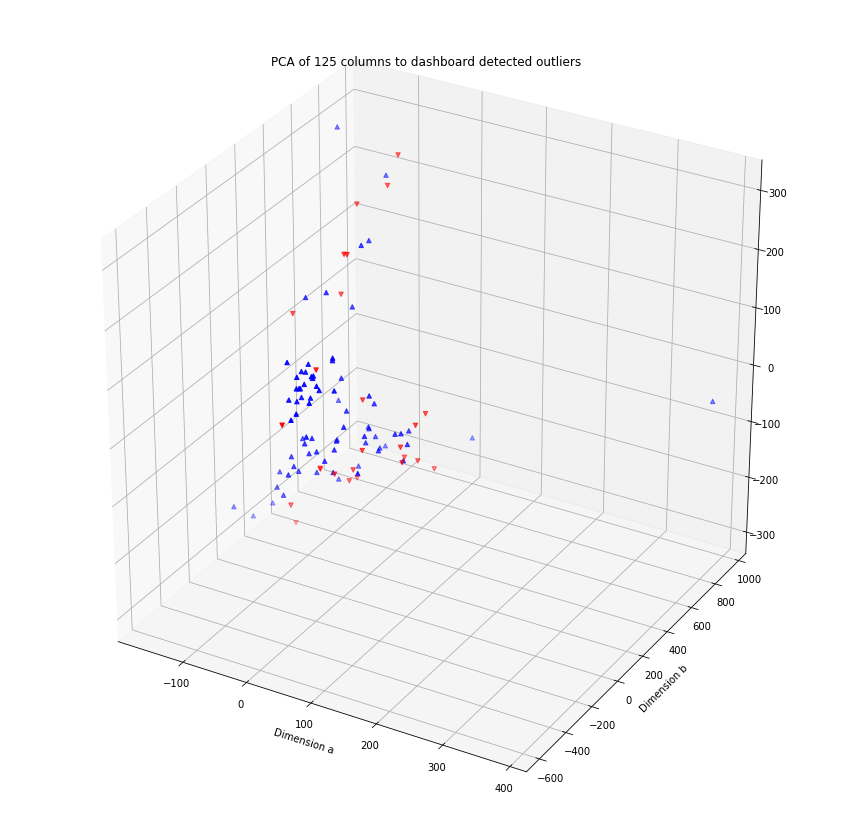

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

#your code

fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(red.c,red.a, red.b, marker="v", color="r") # "P"
ax.scatter( blue.c,blue.a,blue.b, marker="^", color="b") # "P"
plt.xlabel('Dimension a')
plt.ylabel('Dimension b')

plt.title('PCA of 125 columns to dashboard detected outliers')
# not outliers ax.scatter(pca_data.a,pca_data.b,pca_data.c, marker=".")

plt.show()

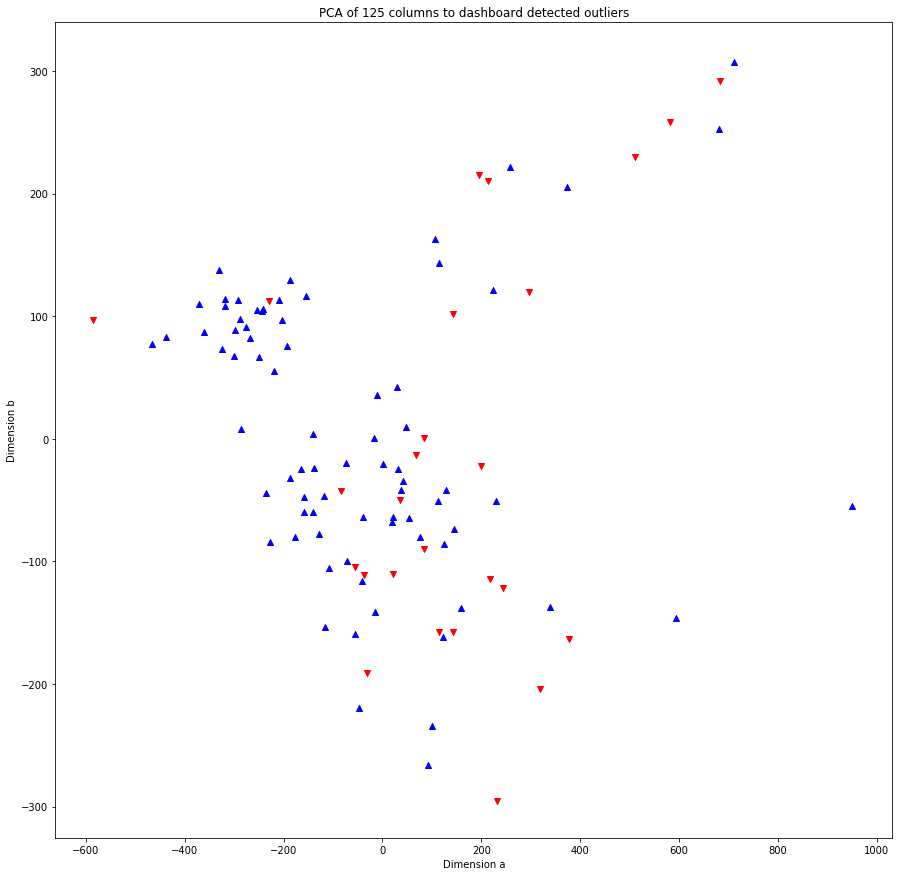

In [63]:
from sklearn import decomposition
pca=decomposition.PCA()
pca.n_components=2
pca_data=pca.fit_transform(df_outliers)
pca_data=pd.DataFrame(pca_data)
pca_data.rename(columns={0:"a",1:"b"}, inplace=True)
#pca_data.shape

pca_data["date"]=df_date
pca_data["outliers"]=[0 if d in list(dataset.date) else 1 for d in list(pca_data.date)]
#print(list(pca_data.outliers))
#pca_data.head()

red= pca_data[pca_data["outliers"]==1][["a","b"]]
blue= pca_data[pca_data["outliers"]==0][["a","b"]]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

#your code

fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111)
ax.scatter(red.a, red.b, marker="v", color="r") # "P"
ax.scatter( blue.a,blue.b, marker="^", color="b") # "P"
plt.xlabel('Dimension a')
plt.ylabel('Dimension b')

plt.title('PCA of 125 columns to dashboard detected outliers')
# not outliers ax.scatter(pca_data.a,pca_data.b,pca_data.c, marker=".")

plt.show()

# 27.12 Elliptic envelope and dimensionality reduction

- This was done before the 3d outliers removal

- Reduce to 2D and plot graph of outliers
- https://medium.com/analytics-vidhya/a-complete-guide-on-dimensionality-reduction-62d9698013d2

How can i get back the outliers out of the decicions boundary, after a dimensionality reduction?

In [55]:
def outliers_graph(df, outlier_method, outliers_begin, threshold, xmin, xmax):
    
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(xmin, xmax, 100))
    Z = outlier_method.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20, 14))
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, xmax), cmap=plt.cm.Blues_r)
    #a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
    #plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='orange')
    b = plt.scatter(df.iloc[:outliers_begin, 0], df.iloc[:outliers_begin, 1], c='white', s=20, edgecolor='k')
    c = plt.scatter(df.iloc[outliers_begin:, 0], df.iloc[outliers_begin:, 1], c='black', s=20, edgecolor='k')
    plt.axis('tight')
    '''
    # In case I'll use the axis unemployment and 1D proyection
    plt.ylim((-5,105)) # forcing the graph to fit my target range
    plt.title('Elliptic envelope over my target and a 1D proyection of my training set', fontsize=20)
    plt.xlabel('1D proyection', fontsize=16)
    plt.ylabel('Unemployment', fontsize=16)
    #
    '''
    plt.legend(
        [b,c],["Valid instances", "outliers"],
        #[a.collections[0], b, c],
        #['Decision boundary', 'Valid instances', 'Outliers'],
        prop=matplotlib.font_manager.FontProperties(size=34),
        loc='lower right')
    plt.savefig('input/outliers.png')
    plt.show()    

In [56]:
asdfasdfasdf

NameError: name 'asdfasdfasdf' is not defined

In [ ]:
outliers_dect= df.drop(columns=["date","unemployment"])
# this is for having a 2D representation with everything. The result is visually cool
from sklearn import decomposition
pca=decomposition.PCA()
pca.n_components=2
pca_data=pca.fit_transform(outliers_dect)
pca_data=pd.DataFrame(pca_data)
pca_data.rename(columns={0:"a",1:"b"}, inplace=True)
pca_data.shape

In [ ]:
pca_data.head()

In [ ]:
# outliers detection using stats
outlier_method = EllipticEnvelope().fit(pca_data)
scores_pred = outlier_method.decision_function(pca_data)
threshold = stats.scoreatpercentile(scores_pred, 20) # remove just the heaviest outliers

In [ ]:
df["outliers_score"]=scores_pred
df =df[df["outliers_score"]>=threshold]
df.shape

In [ ]:
# Ratio de outliers.
print("%.3f %%" % (100*len(scores_pred[scores_pred < threshold])/len(scores_pred)), "of the instances were removed")

In [ ]:
# sending processed dataset
df.to_csv("input/dataset_final_processed.csv")

In [ ]:
blacks = len(scores_pred)-len(scores_pred[scores_pred<threshold])

In [ ]:
# Dibujar gráfica de outliers.
plot_min=int(min(list(pca_data.min())))
plot_max=int(max(list(pca_data.max())))
outliers_graph(pca_data, outlier_method, blacks, threshold, plot_min, plot_max)